In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

from tqdm.notebook import tqdm
from torchsummary import summary

from VAE_Classes import VAE_Heat, NetworkTrainer

os.getcwd()

'c:\\GitRepos\\surrogate-spr\\npk-puff-surrogate'

Load the previously fitted VAE network. After fitting the conditional flow, the flow is applied multiple times and then backtransformed using the VAE.

In [2]:
vae_kwargs = {"latent_dim": 256, "first_channel": 4, "max_channels": 8, "input_size": (97, 97)}
vae_trainer = NetworkTrainer(VAE_Heat, model_kwargs=vae_kwargs, device="cpu", beta_start=10)

Model parameters loaded from model_parameters/vae/vae_upsample_ld256_fc4_maxchannel8_parameters.pth


Loading the data generated using the simulator. It will just be a "cold" plate with 5 "hot" points, of dispersing heat

In [34]:
data_input_original = torch.load("./data/vae/inputs_simulation_number250_timesteps250_k1.pth").unsqueeze(1)
data_output_original = torch.load("./data/vae/outputs_simulation_number250_timesteps250_k1.pth").unsqueeze(1)

with torch.no_grad():
    data_input, _ = vae_trainer.model.encode(data_input_original)
    data_output, _ = vae_trainer.model.encode(data_output_original)

data_input = data_input.unsqueeze(1)
data_output = data_output.unsqueeze(1)

data = torch.cat([data_input, data_output], dim=1)

In [35]:
test_input = data_input[0:1000].squeeze(1)
test_output = data_output[0:1000].squeeze(1)

In [36]:
%%time
sigma = 0.1
dim = data_input.shape[2]
batch_size = 256
t_span=torch.linspace(0, 1, 100)

model = MLP(dim=dim, w=128, time_varying=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
FM = ConditionalFlowMatcher(sigma=sigma)

data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

CPU times: total: 0 ns
Wall time: 3 ms


Training the Flow model

  0%|          | 0/1000 [00:00<?, ?it/s]

[Epoch 11/1000]


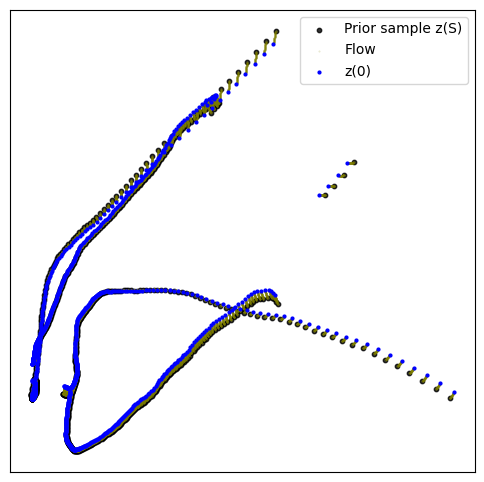

[Epoch 500/1000]


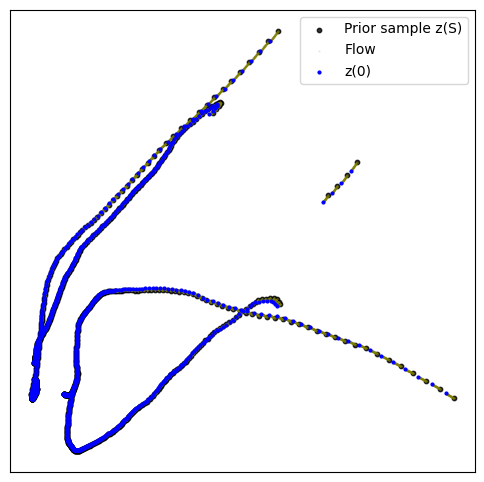

[Epoch 1000/1000]


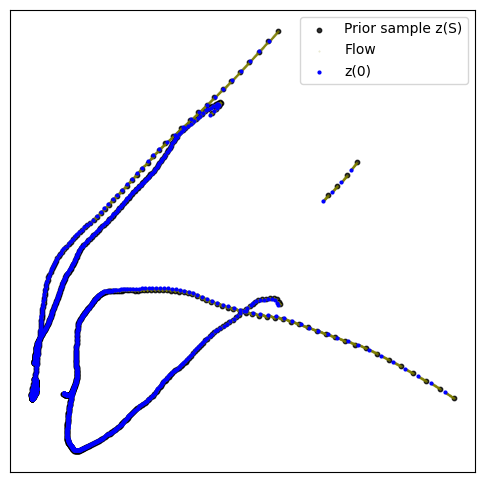

In [37]:
num_epochs = 1000
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for batch in data_loader:
        
        x0 = batch[:,0,:]
        x1 = batch[:,1,:]

        optimizer.zero_grad()
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

    pbar.set_postfix({"loss": f"{1000000*loss.item():0.3f}"})

    if (epoch+1)%500==0 or epoch==10:

        print(f"[Epoch {epoch}/{num_epochs}]")
        node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

        with torch.no_grad():
            traj = node.trajectory(test_input, t_span)
            plot_trajectories(traj.cpu().numpy())

In [38]:
num_obs = data_input.shape[0]
length_experiment = 249

idx_list = [k for k in range(0, 34000, 249)]

current_state = data_input[idx_list, 0, :]
simulation = current_state.unsqueeze(1)

node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

with torch.no_grad():
    pbar = tqdm(range(length_experiment))
    
    for iteration in pbar:
        current_state = simulation[:, iteration, :]
        next_traj_points = node.trajectory(current_state, t_span)[99] # 100 shouldnt be hardcoded
        simulation = torch.cat((simulation, next_traj_points.unsqueeze(1)), dim=1)

  0%|          | 0/249 [00:00<?, ?it/s]

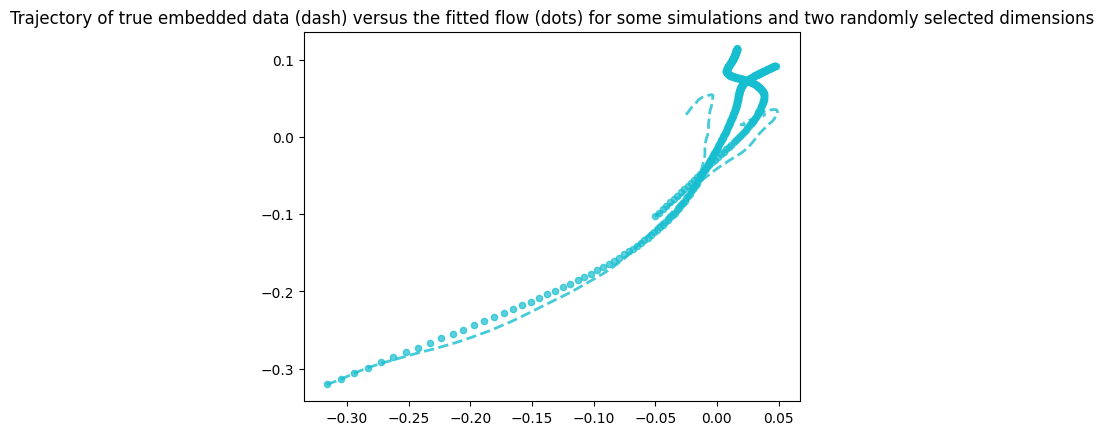

In [46]:
data_plot = data_input.view(150, 249, -1)
# data_input_original = data_input_original.view(150, 249, -1)

dims = torch.randint(256, size=(2,))
simulations = torch.randint(137, size=(2,))

for idx in simulations:
    color = plt.cm.tab10(idx)
    trajectory = simulation[idx, :, :]
    
    plt.scatter(trajectory[:, 0], trajectory[:, 1], color=color, s=20, alpha=0.7)
    plt.plot(data_plot[idx, :, 0], data_plot[idx, :, 1], color=color, linestyle='--', linewidth=2, alpha=0.8)
    plt.title("Trajectory of true embedded data (dash) versus the fitted flow (dots) for some simulations and two randomly selected dimensions")

plt.show()

Take the last timesteps of the flow network, and transform back using the decoder of the VAE.

In the results below, the top row is simulations obtained by encoding the points, applying the flow iteratively, and decoding. The second is the true end of the simulation and the third row shows the difference

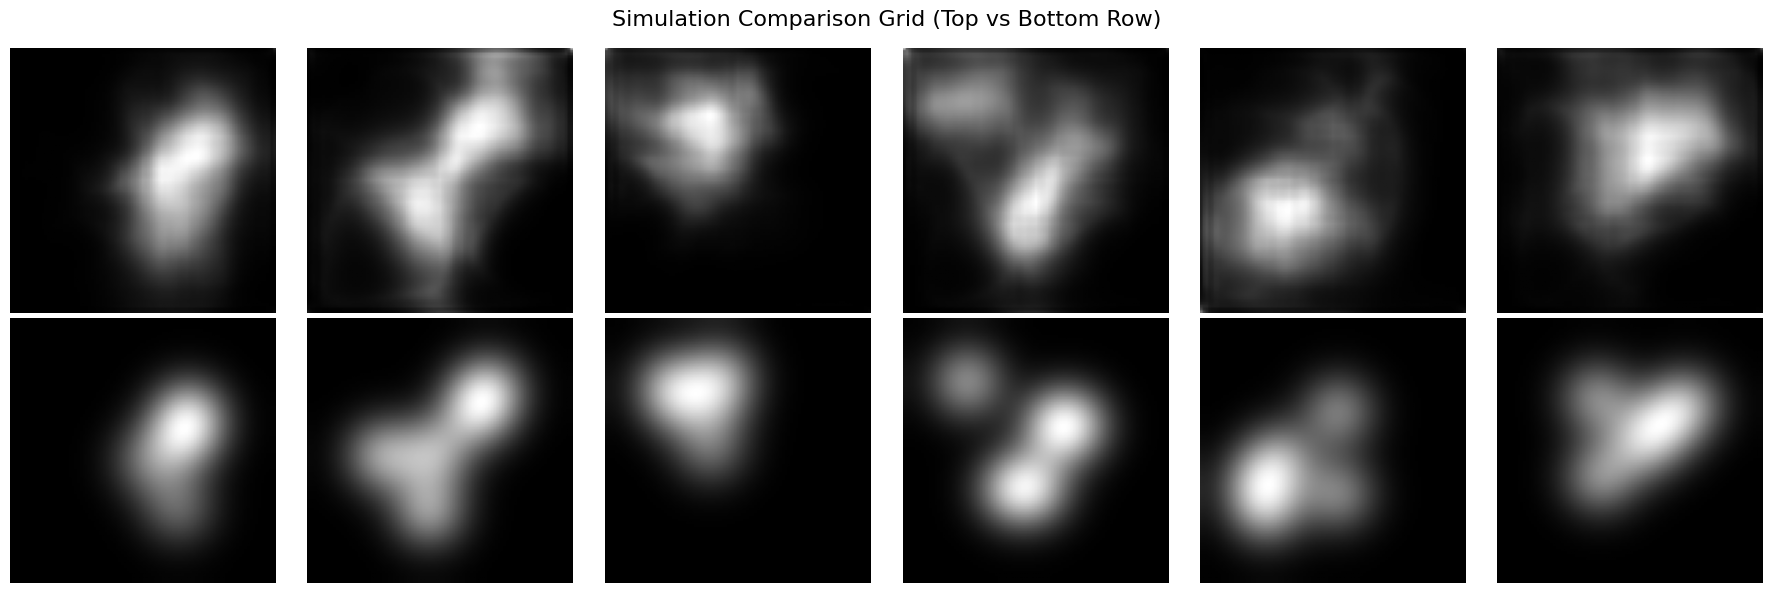

In [67]:
simulation_last_original = vae_trainer.model.decode(simulation[:, -1, :])

num_samples = 6
indices = torch.randperm(simulation_last_original.size(0))[:num_samples]

simulation_last_original_sample = simulation_last_original[indices]  

top_row = simulation_last_original[indices]  
middle_row = data_input_original.view(150, 249, 1, 97, 97)[indices, -1, :, :]
# bottom_row = top_row - middle_row

fig, axes = plt.subplots(2, num_samples, figsize=(18, 6))
for i in range(num_samples):
    img_top = top_row[i, 0].detach().cpu().numpy()
    axes[0, i].imshow(img_top, cmap='gray')
    axes[0, i].axis('off')

    img_bottom = middle_row[i, 0].detach().cpu().numpy()
    axes[1, i].imshow(img_bottom, cmap='gray')
    axes[1, i].axis('off')

    # img_bottom = bottom_row[i, 0].detach().cpu().numpy()
    # axes[2, i].imshow(img_bottom, cmap='gray')
    # axes[2, i].axis('off')

plt.suptitle('Simulation Comparison Grid (Top vs Bottom Row)', fontsize=16)
plt.tight_layout()
plt.show()